In [1]:
from __future__ import print_function
import os
import numpy as np
import pandas as pd
import geopandas as gp
import matplotlib.pylab as pl
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [7]:
datdir = os.getenv("PUIDATA")
if datdir == None or datdir == "":
    datdir = os.getenv("HOME") + "/PUIdata"
srcdir = datdir + "/Clustering"
"""
# The following commands would download the data if it hasn't been done yet
site = "ftp://ftp.census.gov
for year in range(94:102):
    yr = "{:02d}".format(year % 100)
    system("wget " + site + "/Econ2001_And_Earlier/CBP_CSV/zbp" + yr + "totals.zip")
    system("mv zbp" + yr + "totals.zip " + srcdir)
for year in range(2:15):
    yr = "{:02d}".format(year)
    system("wget " + site + "econ20" + yr + "/CBP_CSV/zbp" + yr + "totals.zip")
    system("mv zbp" + yr + "totals.zip " + srcdir)
"""
year = 94
df_yr = {}
# import zipfiles # Used if reading directly from zip files
while year != 15:
    yr = str(year)
    if year < 20:
        estyr = "est{:4d}".format(year + 2000)
    else:
        estyr = "est{:4d}".format(year + 1900)
    # Start each year by reading it in to a DataFrame
    # I had unzipped the files in order to look at them, if this had not been done,
    # the commented command would by used
    df_yr[yr] = pd.DataFrame.from_csv(srcdir + "/zbp{:02d}totals.txt".format(year))
    # zf = zipfile.ZipFile(srcdir + "/zbp{:02}totals.zip".format(year))
    # df_yr[yr] = pd.read_csv(zf.open("zbp{:02d}totals.txt".format(year)))
    # Change the "est" or "EST" column to include the year
    df_yr[yr].rename(columns={"est" : estyr}, inplace=True)
    df_yr[yr].rename(columns={"EST" : estyr}, inplace=True)
    if "ZIP" in df_yr[yr].columns:
        df_yr[yr].rename(columns={"ZIP" : "zip"})
    if "zip" in df_yr[yr].columns:
        df_yr[yr].set_index(["zip"], inplace=True)
    # Remove zip codes that are not in NYC
    df_yr[yr] = df_yr[yr].loc[(df_yr[yr].index >= 10000) & (df_yr[yr].index < 11500)]
    df_yr[yr] = df_yr[yr].loc[(df_yr[yr].index < 10500) | (df_yr[yr].index >= 11000)]
    # Drop columns other than number of establishments
    df_yr[yr] = df_yr[yr][[estyr]]
    year = (year + 1) % 100
# Merge each individual Series of zip code, establishments by year into one DataFrame of
# zip code, est1994, est1995, ..., est2014
df = df_yr["94"]
year = 95
# Use the while loop to control the order of the columns
while year != 15:
    df = pd.merge(df, df_yr[str(year)], how='inner', left_index=True, right_index=True)
    year = (year + 1) % 100
df.head(5)

,est1994,est1995,est1996,est1997,est1998,est1999,est2000,est2001,est2002,est2003,...,est2005,est2006,est2007,est2008,est2009,est2010,est2011,est2012,est2013,est2014
10001,6999,7088,7075,7154,7254,7233,7317,7188,7141,7084,...,7312,7415,7549,7472,7305,7241,7227,7235,7273,7369
10002,1784,1819,1919,2049,2003,2085,2277,2543,2269,2402,...,2682,2686,2685,2691,2775,2872,2912,2954,2988,2972
10003,3256,3377,3417,3535,3649,3659,3683,3602,3616,3704,...,3867,3909,4049,4071,4099,4113,4159,4214,4277,4333
10004,1115,1124,1133,1173,1176,1233,1294,1247,1253,1252,...,1260,1311,1370,1376,1379,1398,1404,1442,1479,1554
10005,1076,1109,1216,1227,1270,1242,1287,1249,1244,1200,...,1214,1259,1273,1291,1274,1266,1301,1273,1296,1321


In [8]:
means = df.mean(axis=1)
stds = df.std(axis=1)
print(means.head(5))
print(stds.head(5))

10001    7252.428571
10002    2472.285714
10003    3826.904762
10004    1297.904762
10005    1243.523810
dtype: float64
10001    137.793531
10002    401.674637
10003    313.598295
10004    120.916874
10005     59.419373
dtype: float64


In [9]:
summ = pd.DataFrame([means, stds]).transpose()
summ.rename(columns={0 : "emean", 1 : "estd"}, inplace=True)
summ.head(5)

,emean,estd
10001,7252.428571,137.793531
10002,2472.285714,401.674637
10003,3826.904762,313.598295
10004,1297.904762,120.916874
10005,1243.523810,59.419373


In [10]:
df = pd.merge(df, summ, how='inner', left_index=True, right_index=True)
df.head(5)

,est1994,est1995,est1996,est1997,est1998,est1999,est2000,est2001,est2002,est2003,...,est2007,est2008,est2009,est2010,est2011,est2012,est2013,est2014,emean,estd
10001,6999,7088,7075,7154,7254,7233,7317,7188,7141,7084,...,7549,7472,7305,7241,7227,7235,7273,7369,7252.428571,137.793531
10002,1784,1819,1919,2049,2003,2085,2277,2543,2269,2402,...,2685,2691,2775,2872,2912,2954,2988,2972,2472.285714,401.674637
10003,3256,3377,3417,3535,3649,3659,3683,3602,3616,3704,...,4049,4071,4099,4113,4159,4214,4277,4333,3826.904762,313.598295
10004,1115,1124,1133,1173,1176,1233,1294,1247,1253,1252,...,1370,1376,1379,1398,1404,1442,1479,1554,1297.904762,120.916874
10005,1076,1109,1216,1227,1270,1242,1287,1249,1244,1200,...,1273,1291,1274,1266,1301,1273,1296,1321,1243.523810,59.419373


In [11]:
whitened = df
for yr in range(1994, 2015):
    col = "est{}".format(yr)
    whitened[col] = (whitened[col] - whitened.emean) / whitened.estd
whitened.head(5)

,est1994,est1995,est1996,est1997,est1998,est1999,est2000,est2001,est2002,est2003,...,est2007,est2008,est2009,est2010,est2011,est2012,est2013,est2014,emean,estd
10001,-1.839191,-1.193297,-1.287641,-0.714319,0.011404,-0.140998,0.468610,-0.467573,-0.808663,-1.222326,...,2.152288,1.593481,0.381523,-0.082940,-0.184541,-0.126483,0.149292,0.845986,7252.428571,137.793531
10002,-1.713540,-1.626405,-1.377447,-1.053802,-1.168323,-0.964178,-0.486179,0.176049,-0.506095,-0.174982,...,0.529569,0.544506,0.753631,0.995120,1.094703,1.199265,1.283911,1.244077,2472.285714,401.674637
10003,-1.820497,-1.434653,-1.307101,-0.930824,-0.567301,-0.535414,-0.458882,-0.717175,-0.672532,-0.391918,...,0.708216,0.778369,0.867655,0.912298,1.058983,1.234367,1.435260,1.613833,3826.904762,313.598295
10004,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,-0.379639,...,0.596238,0.645859,0.670669,0.827802,0.877423,1.191688,1.497684,2.117945,1297.904762,120.916874
10005,-2.819347,-2.263972,-0.463213,-0.278088,0.445582,-0.025645,0.731684,0.092162,0.008014,-0.732485,...,0.496070,0.799002,0.512900,0.378264,0.967297,0.496070,0.883150,1.303888,1243.523810,59.419373


In [12]:
from PIL import Image

import sklearn.cluster

In [13]:
whitened.drop(["emean", "estd"], axis=1, inplace=True)

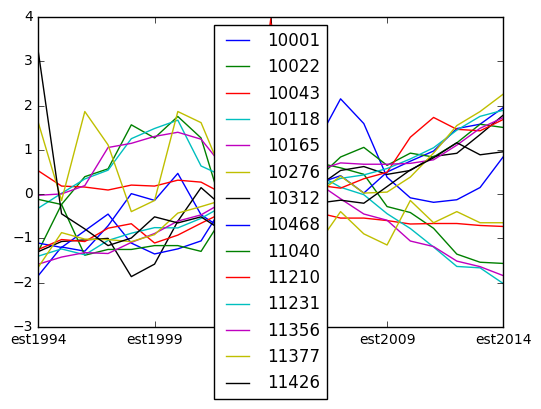

In [14]:
samp = whitened.index[::20]
sampdf = whitened.loc[samp]
sampdf.transpose().plot()

In [30]:
initcents4 = np.array([10001, 11426, 10276, 10118])
initcents6 = np.array([10001, 11426, 10276, 10118, 10165, 11210])
initcents8 = np.array([10001, 11426, 10276, 10118, 10165, 11210, 10043, 10022])

stored  = {}
def tsdist(srcdf, zcode1, zcode2):
    if zcode1 in stored.keys():
        if zcode2 in stored[zcode1].keys():
            return stored[zcode1][zcode2]
    else:
        stored[zcode1] = {}
    if not(zcode2 in stored.keys()):
        stored[zcode2] = {}
    sumsqs = 0
    for col in srcdf.columns:
        sumsqs += (srcdf[col].loc[zcode1] - srcdf[col].loc[zcode2]) ** 2
    dist = np.sqrt(sumsqs)
    stored[zcode1][zcode2] = dist
    stored[zcode2][zcode1] = dist
    return dist

In [24]:
print(distsq(whitened.loc[10007], whitened.loc[10040]))
print(distsq(whitened.loc[10007], whitened.loc[10033], 21.89))

21.8893020281
0


In [28]:
def find_closest(ind, srcdf, lst):
    shortest = -1.0
    nearest = 0
    for chk in lst:
        dist = tsdist(srcdf, ind, chk)
        if shortest < 0 or dist < shortest:
            shortest = dist
            nearest = chk
    return nearest

def distsq(frompt, topt, tol=np.infty):
    dist2 = 0
    for i in range(len(frompt)):
        dist2 += (frompt[i] - topt[i]) ** 2
        if dist2 >= tol:
            return 0
    return dist2

def closest_topt(pt, srcdf):
    shortest = -1.0
    nearest = 0
    for zp in srcdf.index:
        if shortest < 0:
            nearest = zp
            shortest = distsq(pt, srcdf.loc[zp])
        else:
            d2 = distsq(pt, srcdf.loc[zp], shortest)
            if d2 > 0:
                shortest = d2
                nearest = zp
    return nearest

def newcenters(lst, srcdf):
    sublists = {}
    for k in lst:
        if not(lst[k] in sublists.keys()):
            sublists[lst[k]] = []
        sublists[lst[k]].append(k)
    means = {}
    newcents = []
    for k in sublists.keys():
        means[k] = srcdf.loc[sublists[k]].mean()
        newcents.append(closest_topt(means[k], srcdf.loc[sublists[k]]))
    return newcents

def arrequal(arr1, arr2):
    if len(arr1) != len(arr2):
        return 0
    for i in range(len(arr1)):
        if arr1[i] != arr2[i]:
            return 0
    return 1

In [31]:
fincents4 = initcents4
fincents6 = initcents6
fincents8 = initcents8
initlist = [initcents4, initcents6, initcents8]
finlist = [fincents4, fincents6, fincents8]

clusters = []
for a in range(3):
    clusters.append({})
    centlist = finlist[a]
    for iterate in range(300):
        for zp in whitened.index:
            clusters[a][zp] = find_closest(zp, whitened, centlist)
        finlist[a] = newcenters(clusters[a], whitened)
        if arrequal(finlist[a], centlist):
            break
        else:
            centlist = finlist[a]

In [32]:
finlist

[[11002, 10165, 11214, 10471],
 [11426, 10021, 10282, 11002, 11354, 10175],
 [10464, 11426, 10019, 10152, 10282, 11242, 11002, 11354]]

In [33]:
mapfr = gp.read_file(srcdir + "/nyc-zip-code-tabulation-areas-polygons.geojson")
mapfr.head(4)

,@id,BLDGpostalCode,CTY_FIPS,OBJECTID,PO_NAME,STATE,ST_FIPS,Shape_Area,Shape_Leng,borough,geometry,postalCode
0,http://nyc.pediacities.com/Resource/PostalCode...,0,081,1,Jackson Heights,NY,36,2.016328e+07,20624.692317,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372
1,http://nyc.pediacities.com/Resource/PostalCode...,0,081,2,Glen Oaks,NY,36,2.260653e+07,23002.816039,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004
2,http://nyc.pediacities.com/Resource/PostalCode...,0,081,3,New Hyde Park,NY,36,6.269333e+06,15749.161511,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040
3,http://nyc.pediacities.com/Resource/PostalCode...,0,081,4,Bellerose,NY,36,4.941836e+07,35932.810639,Queens,POLYGON ((-73.72270447144122 40.75373371438336...,11426


In [43]:
clframe = pd.DataFrame.from_dict(clusters[0], orient='index')
clframe.rename(columns={0 : "4 Clusters"}, inplace=True)
for i in 1, 2:
    clframe = pd.merge(clframe, pd.DataFrame.from_dict(clusters[i], orient='index'),
                       how='inner', right_index=True, left_index=True)
    if i == 1:
        clframe.rename(columns={0 : "6 Clusters"}, inplace=True)
    else:
        clframe.rename(columns={0 : "8 Clusters"}, inplace=True)
print(clframe.size)
print(mapfr.size)
clframe.head(4)

819
3144


,4 Clusters,6 Clusters,8 Clusters
10268,11002,11002,11002
10270,10165,10021,10152
10271,10165,10175,11242
10274,11002,11002,11002


In [58]:
mapfr["zipCode"] = mapfr.postalCode.astype(int)
mapfr = pd.merge(mapfr, clframe, how='left', left_on='zipCode', right_index=True)
mapfr.head(5)

,@id,BLDGpostalCode,CTY_FIPS,OBJECTID,PO_NAME,STATE,ST_FIPS,Shape_Area,Shape_Leng,borough,geometry,postalCode,zipCode,4 Clusters,6 Clusters,8 Clusters
0,http://nyc.pediacities.com/Resource/PostalCode...,0,081,1,Jackson Heights,NY,36,2.016328e+07,20624.692317,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372,11372,11214.0,11354.0,11354.0
1,http://nyc.pediacities.com/Resource/PostalCode...,0,081,2,Glen Oaks,NY,36,2.260653e+07,23002.816039,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004,11004,11214.0,11354.0,11354.0
2,http://nyc.pediacities.com/Resource/PostalCode...,0,081,3,New Hyde Park,NY,36,6.269333e+06,15749.161511,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040,11040,11214.0,11354.0,11354.0
3,http://nyc.pediacities.com/Resource/PostalCode...,0,081,4,Bellerose,NY,36,4.941836e+07,35932.810639,Queens,POLYGON ((-73.72270447144122 40.75373371438336...,11426,11426,10471.0,11426.0,11426.0
4,http://nyc.pediacities.com/Resource/PostalCode...,0,081,5,Fresh Meadows,NY,36,6.938587e+07,38693.565676,Queens,POLYGON ((-73.81088634744755 40.72717187575918...,11365,11365,11214.0,11354.0,11354.0


In [74]:
def plot_clusters(gdf, col):
    f, ax = pl.subplots(figsize=(10, 10))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    gdf.plot(column=col, ax=ax)
    pl.title("New York City zip codes in {}".format(col))

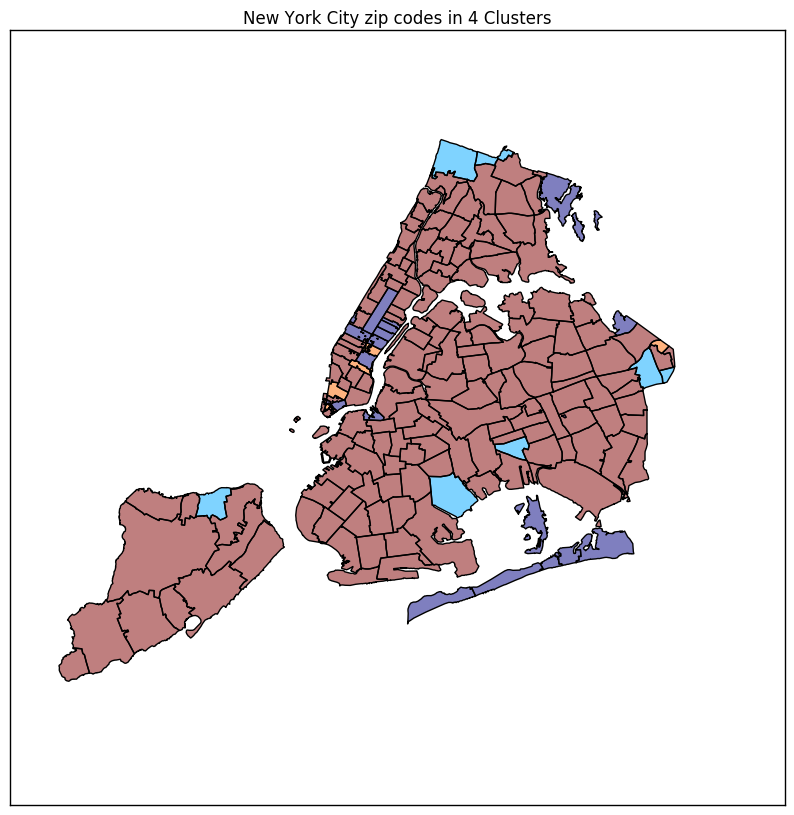

In [75]:
plot_clusters(mapfr, '4 Clusters')

Figure 1. The results from clustering the zip code time series into 4 clusters.

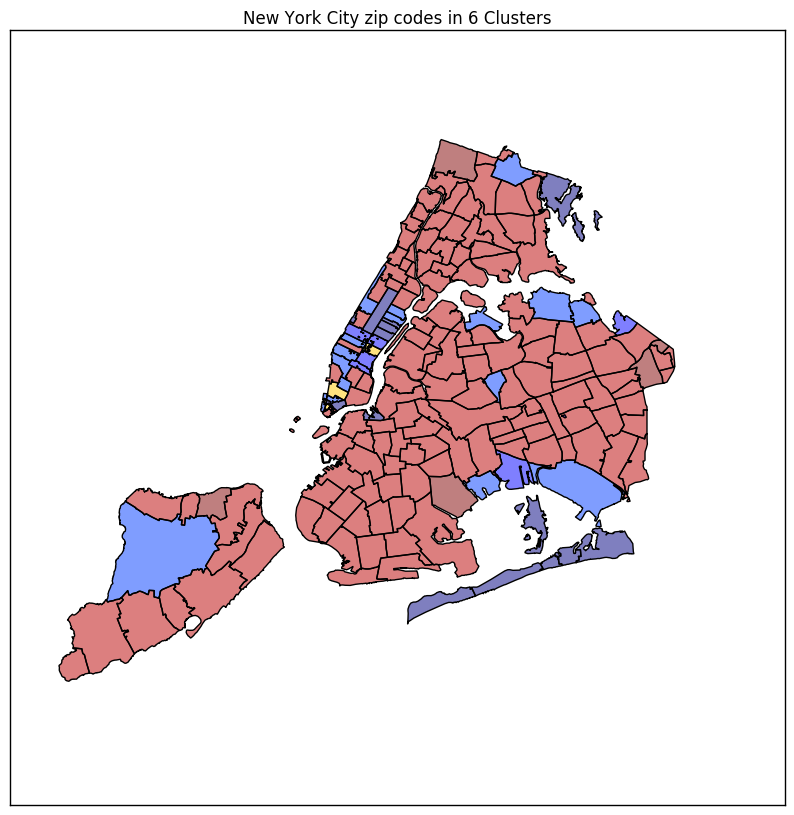

In [66]:
plot_clusters(mapfr, "6 Clusters")

Figure 2. The results from clustering the zip code time series into 6 clusters.

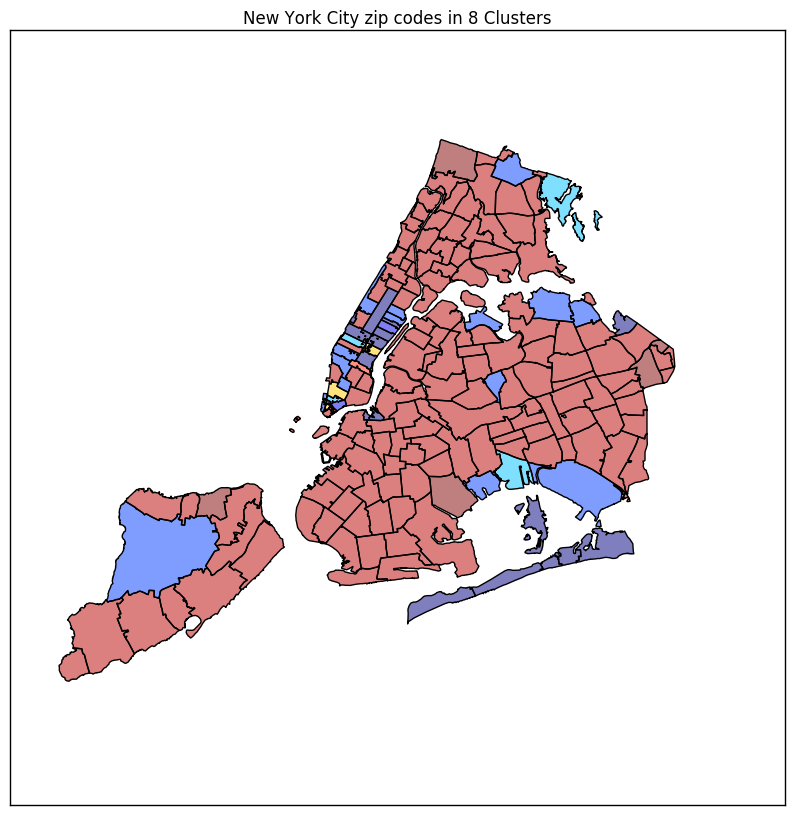

In [76]:
plot_clusters(mapfr, "8 Clusters")

Figure 3. The results from clustering the zip code time series into 8 clusters.

In [ ]:
from sklearn.cluster import AgglomerativeClustering
agc = AgglomerativeClustering(compute_full_tree=True, affinity=tsdist)